<a href="https://colab.research.google.com/github/JonathanKolb/MLNNs_project/blob/fluffy-unicorns/CS401_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic challenge part 3
In this notebook, we will be covering all of the steps required to train, tune and assess a neural network.

**[Part 1](https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation)** of this series dealt with the pre-processing and manipulation of the data. This notebook will make use of the datasets that were created in the first part.

We will do each of the following:
- train and test a neural network model
- use grid search to optimize the hyperparameters
- submit predictions for the test set

**[Part 2](https://www.kaggle.com/jamesleslie/titanic-random-forest-grid-search)** covered the use of a random forest for tackling this challenge. Now let's see if we can beat that model with a neural network!
> NOTE: make sure to use a GPU for this notebook, as it will be significantly faster to train

>[Titanic challenge part 3](#scrollTo=3jq6wLfnS5_o)

>[Load packages and data](#scrollTo=NbEufoDGTMqH)

>[Pre-processing](#scrollTo=--MpK8w_TRoe)

>>[2.1. Encode Categorical Variables](#scrollTo=dY_SXhKDziPH)

>>[2.2. Scale Continuous Variables](#scrollTo=zvZPfSHoT3cb)

>[Neural Network](#scrollTo=CGgKlm9SUDq0)

>>[3.1. Cross-validation](#scrollTo=7C3fRFRhUILg)

>>>[Create neural network model](#scrollTo=l6lToqRJUK5P)

>>>[Train model](#scrollTo=_fXOR-f0URU7)

>>>[Assess results](#scrollTo=g0Yxs278UV08)

>>[3.2. Grid search](#scrollTo=E38PCCVlaCaR)

>>>[3.2.1. batch size and epochs](#scrollTo=E38PCCVlaCaR)

>>>[3.2.2. Optimization Algorithm](#scrollTo=CSF1lAaqEPAq)

>>>[3.2.3. Hidden neurons](#scrollTo=YMxcOu7lp6WQ)

>>>[3.2.4. Dropout](#scrollTo=tqUWxJ6nqAnB)

>>[3.3. Make Predictions on Test Set](#scrollTo=kN6l8ZFaqNAm)

>>[3.4. Output Final Predictions](#scrollTo=4Qcj66VhqS8M)

>[Logistic Regression](#scrollTo=v2_iNytuyLp7)

>[Random Forrest](#scrollTo=yIwgxa3pyQXn)

>[SVCs](#scrollTo=m8j517wzyVIH)



<a id="loading"></a>
# 1. Load packages and data
[Back to Top](#scrollTo=3jq6wLfnS5_o)

Mount the Google Drive to the runtime so I can access files from there.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CS401/input"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS401/input
/content/drive/MyDrive/CS401/input


In [ ]:
# general packages
import numpy as np
import pandas as pd
import seaborn as sns
import os

# packages for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

# packages for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# packages for neural network
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# packages to set the random seed
from numpy.random import seed
from tensorflow.random import set_seed

# packages for logistic regression
from sklearn.linear_model import LogisticRegression

# packages for random forest
from sklearn.ensemble import RandomForestClassifier

# package for Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

# package for SVCs
from sklearn.svm import SVC

In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("../input"))
print(os.listdir("../input/titanic_cleaned_data"))

['titanic_cleaned_data', 'Neural_Network_Solution.csv']
['test_clean.csv', 'train_clean.csv']


The so called ```test_clean.csv``` data is actually the unlabeled data that is to be predicted. So as opposed to the original notebook I read the data in as ```unlabeled``` so the destintion is clear.

In [ ]:
# Load data as Pandas dataframe
train = pd.read_csv('../input/titanic_cleaned_data/train_clean.csv')
unlabeled = pd.read_csv('../input/titanic_cleaned_data/test_clean.csv')
df = pd.concat([train, unlabeled], axis=0, sort=True)

In [ ]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [ ]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309.0,NaN,NaN,NaN,29.562391,13.16536,0.17,22.0,30.0,35.5,80.0
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309.0,NaN,NaN,NaN,0.883881,1.583639,0.0,0.0,0.0,1.0,10.0
Fare,1309.0,NaN,NaN,NaN,33.276193,51.743584,0.0,7.8958,14.4542,31.275,512.3292
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="pre-processing"></a>
# 2. Pre-processing
[Back to Top](#scrollTo=3jq6wLfnS5_o)



<a id="encoding"></a>
## 2.1. Encode Categorical Variables
We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are `Embarked`, `Sex` and `Title`.   

The `Sex` variable can be encoded into single 1-or-0 column, but the other variables will need to be [one-hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Regular label encoding assigns some category labels higher numerical values. This implies some sort of scale (Embarked = 1 is not **more** than Embarked = 0 - it's just _different_). One Hot Encoding avoids this problem.   

We will assume that there is some ordinality in the `Pclass` variable, so we will leave that as a single column.


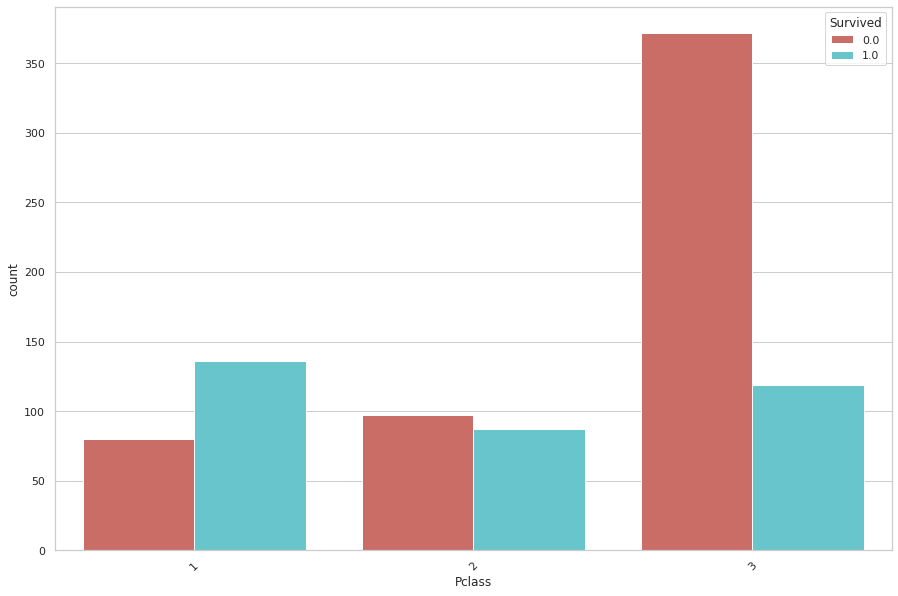

In [ ]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

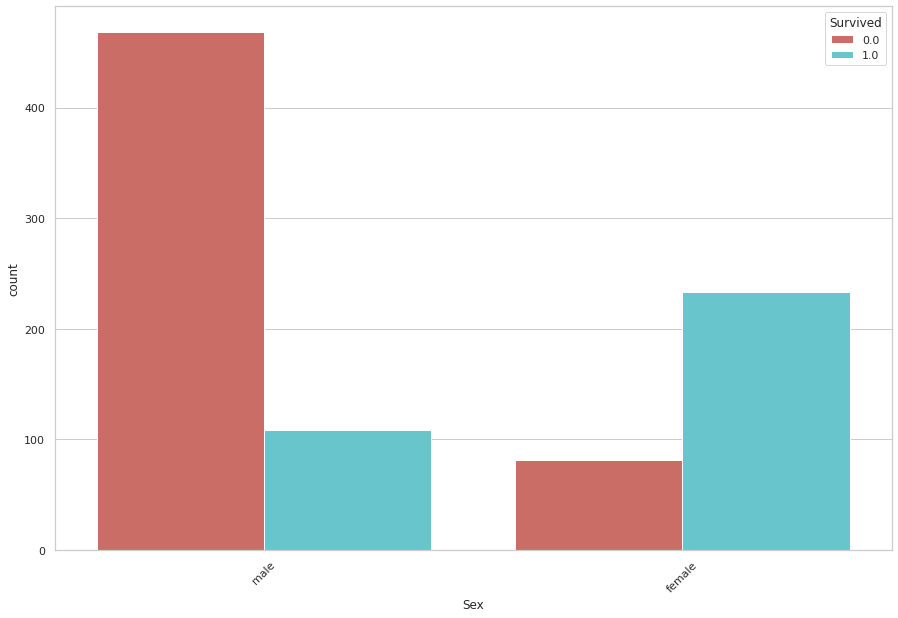

In [ ]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

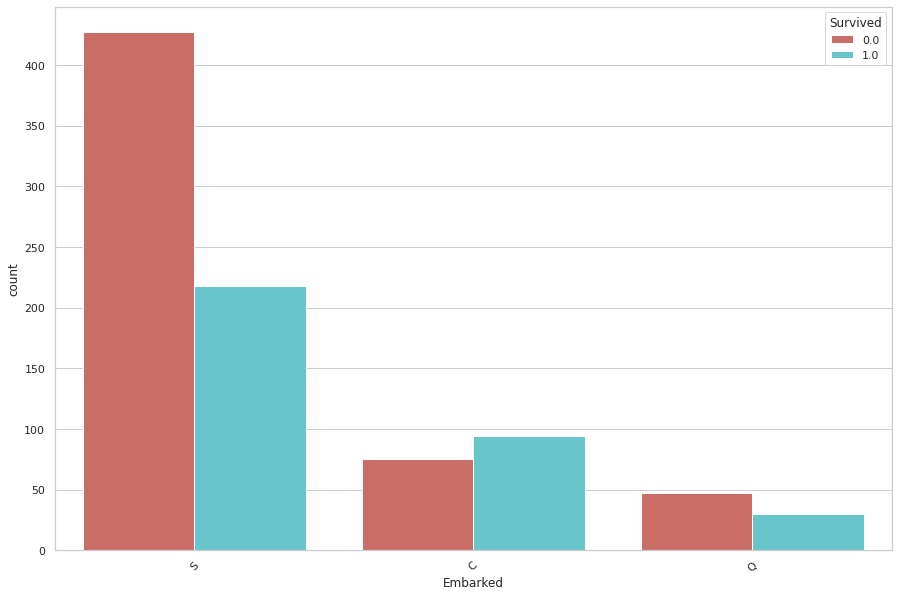

In [ ]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [ ]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [ ]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [ ]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,0,0,1,0,0,0,1,0,0
1,38.0,1,71.2833,0,1,0,1,1.0,1,0,0,0,0,0,0,1,0
2,26.0,0,7.9250,0,3,0,0,1.0,0,0,1,0,0,1,0,0,0
3,35.0,1,53.1000,0,1,0,1,1.0,0,0,1,0,0,0,0,1,0
4,35.0,0,8.0500,0,3,1,0,0.0,0,0,1,0,0,0,1,0,0


## 2.2. Scale Continuous Variables
[Back to Top](#scrollTo=3jq6wLfnS5_o)

The continuous variables need to be scaled. This is done using a standard scaler from SkLearn.

In [ ]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [ ]:
display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,7.327981e-17,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Family_Size,1309.0,1.628440e-17,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Fare,1309.0,2.171254e-17,1.000382,-0.643344,-0.490691,-0.363894,-0.038690,9.261749
Parch,1309.0,1.730218e-17,1.000382,-0.445000,-0.445000,-0.445000,-0.445000,9.956864
Pclass,1309.0,-2.062691e-16,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,6.440031e-01,0.478997,0.000000,0.000000,1.000000,1.000000,1.000000
SibSp,1309.0,-1.628440e-17,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Embarked_C,1309.0,2.070283e-01,0.405331,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,1309.0,9.396486e-02,0.291891,0.000000,0.000000,0.000000,0.000000,1.000000


## 2.3. Train Test Split

Now, all that is left is to feed our data that has been cleaned, encoded and scaled to our neural network.

But first, we need to separate *data_df* back into *train* and *unlabeled* sets.

In [ ]:
train = df[pd.notnull(df['Survived'])]
X_unlabeled = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

Also for the later experiments the training set gets split into train and test set randomly. This allows us to test the predictions on an *unseen* holdout set of the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['Survived'], axis=1),
    train['Survived'],
    test_size=0.2, random_state=42)

<a id="neural-network"></a>
# 3. Neural Network
[Back to Top](#scrollTo=3jq6wLfnS5_o)



## 3.1. Cross-validation
[Back to Top](#scrollTo=3jq6wLfnS5_o)

Keras allows us to make use of cross-validation for training our model. So we will use this to train and assess our first model.

### Create neural network model
For this task, I have kept the model architecture pretty simple. We have one input layer with 17 nodes which feeds into a hidden layer with 8 nodes and an output layer which is used to predict a passenger's survival.   

The output layer has a sigmoid activation function, which is used to 'squash' all our outputs to be between 0 and 1.   

We are going to create a function which allows to parameterise the choice of hyperparameters in the neural network. This might seem a little overly complicated now, but it will come in super handy when we move onto tuning our parameters later.

In [ ]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    set_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [ ]:
model = create_model()
print(model.summary())

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 8)                 136       
                                                                 
 dropout_121 (Dropout)       (None, 8)                 0         
                                                                 
 dense_265 (Dense)           (None, 1)                 9         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


### Train model
At this stage, we have our model. We have chosen a few hyperparameters such as the number of hidden layers, the number of neurons and the activation function.

The next step is to train the model on our training set. This step also requires us to choose a few more hyperparameters such as the loss function, the optimization algorithm, the number of epochs and the batch size.

In [ ]:
# train model on full train set, with 80/20 CV split
# because the model does the random validation split automatically the whole labeled data set can be input
training = model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 77.84%


### Assess results

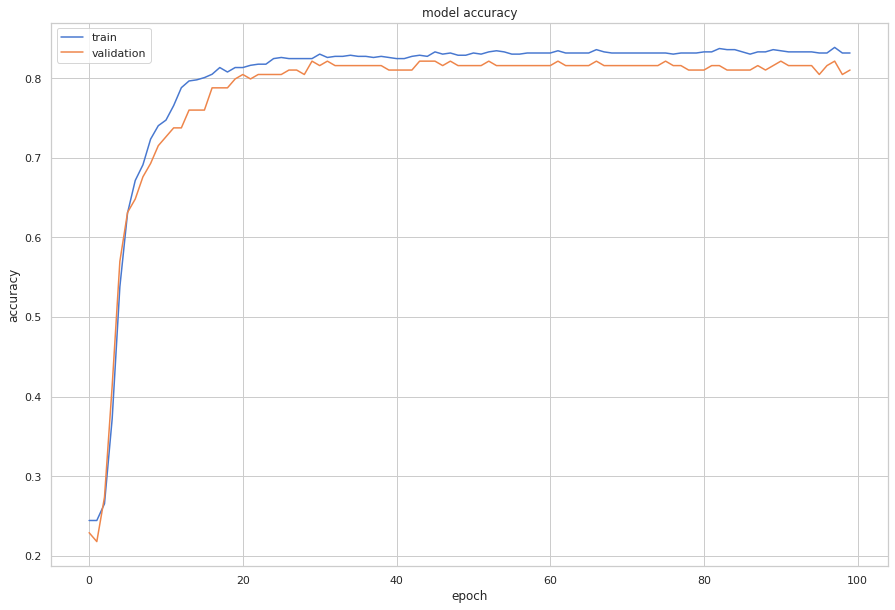

In [ ]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 3.2. Grid search
[Back to Top](#scrollTo=3jq6wLfnS5_o)



### 3.2.1. batch size and epochs
We can see from the graph above that we might be training our network for too long. Let's use **grid search** to find out what the optimal values for `batch_size` and `epochs` are.

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, y_train)

<ipython-input-137-3f1475744285>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...........................batch_size=16, epochs=50; total time=   2.7s
[CV] END ...........................batch_size=16, epochs=50; total time=   3.7s
[CV] END ...........................batch_size=16, epochs=50; total time=   3.3s
[CV] END ..........................batch_size=16, epochs=100; total time=   4.8s
[CV] END ..........................batch_size=16, epochs=100; total time=   5.8s
[CV] END ..........................batch_size=16, epochs=100; total time=   5.8s
[CV] END ...........................batch_size=32, epochs=50; total time=   2.0s
[CV] END ...........................batch_size=32, epochs=50; total time=   2.0s
[CV] END ...........................batch_size=32, epochs=50; total time=   1.8s
[CV] END ..........................batch_size=32, epochs=100; total time=   2.7s
[CV] END ..........................batch_size=32, epochs=100; total time=   3.3s
[CV] END ..........................batch_size=32,

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.830077 using {'batch_size': 32, 'epochs': 100}
0.823045 (0.014875) with: {'batch_size': 16, 'epochs': 50}
0.825858 (0.015732) with: {'batch_size': 16, 'epochs': 100}
0.821638 (0.012907) with: {'batch_size': 32, 'epochs': 50}
0.830077 (0.016036) with: {'batch_size': 32, 'epochs': 100}
0.807591 (0.017595) with: {'batch_size': 64, 'epochs': 50}
0.820232 (0.017600) with: {'batch_size': 64, 'epochs': 100}


### 3.2.2. Optimization Algorithm

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


<ipython-input-139-9b82b8083fd3>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)


[CV] END ............................................opt=SGD; total time=   1.8s
[CV] END ............................................opt=SGD; total time=   1.9s
[CV] END ............................................opt=SGD; total time=   1.9s
[CV] END ............................................opt=SGD; total time=   1.8s
[CV] END ............................................opt=SGD; total time=   1.9s
[CV] END ........................................opt=RMSprop; total time=   2.0s
[CV] END ........................................opt=RMSprop; total time=   2.0s
[CV] END ........................................opt=RMSprop; total time=   2.0s
[CV] END ........................................opt=RMSprop; total time=   2.0s
[CV] END ........................................opt=RMSprop; total time=   2.0s
[CV] END ........................................opt=Adagrad; total time=   1.9s
[CV] END ........................................opt=Adagrad; total time=   2.3s
[CV] END ...................

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.823008 using {'opt': 'Adam'}
0.800492 (0.032956) with: {'opt': 'SGD'}
0.821600 (0.020446) with: {'opt': 'RMSprop'}
0.257008 (0.025227) with: {'opt': 'Adagrad'}
0.254171 (0.035641) with: {'opt': 'Adadelta'}
0.823008 (0.021270) with: {'opt': 'Adam'}
0.823008 (0.021270) with: {'opt': 'Nadam'}


### 3.2.3. Hidden neurons

In [ ]:
seed(42)
set_seed(42)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


<ipython-input-141-870744a6114d>:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


[CV] END ...........................................lyrs=[8]; total time=   3.3s
[CV] END ...........................................lyrs=[8]; total time=   2.0s
[CV] END ...........................................lyrs=[8]; total time=   2.0s
[CV] END ...........................................lyrs=[8]; total time=   2.0s
[CV] END ...........................................lyrs=[8]; total time=   2.0s
[CV] END ..........................................lyrs=[10]; total time=   1.9s
[CV] END ..........................................lyrs=[10]; total time=   2.0s
[CV] END ..........................................lyrs=[10]; total time=   2.4s
[CV] END ..........................................lyrs=[10]; total time=   2.0s
[CV] END ..........................................lyrs=[10]; total time=   2.0s
[CV] END .......................................lyrs=[10, 5]; total time=   2.1s
[CV] END .......................................lyrs=[10, 5]; total time=   3.3s
[CV] END ...................

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.831449 using {'lyrs': [12, 8, 4]}
0.823008 (0.021270) with: {'lyrs': [8]}
0.830031 (0.017697) with: {'lyrs': [10]}
0.831439 (0.019579) with: {'lyrs': [10, 5]}
0.831439 (0.019579) with: {'lyrs': [12, 6]}
0.831449 (0.017335) with: {'lyrs': [12, 8, 4]}


### 3.2.4. Dropout

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


<ipython-input-143-77855fcf2344>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


[CV] END .............................................dr=0.0; total time=   3.3s
[CV] END .............................................dr=0.0; total time=   3.3s
[CV] END .............................................dr=0.0; total time=   3.3s
[CV] END .............................................dr=0.0; total time=   3.3s
[CV] END .............................................dr=0.0; total time=   2.0s
[CV] END ............................................dr=0.01; total time=   3.3s
[CV] END ............................................dr=0.01; total time=   3.3s
[CV] END ............................................dr=0.01; total time=   3.3s
[CV] END ............................................dr=0.01; total time=   2.0s
[CV] END ............................................dr=0.01; total time=   2.4s
[CV] END ............................................dr=0.05; total time=   2.0s
[CV] END ............................................dr=0.05; total time=   3.3s
[CV] END ...................

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.825825 using {'dr': 0.1}
0.823008 (0.021270) with: {'dr': 0.0}
0.824416 (0.018546) with: {'dr': 0.01}
0.824416 (0.018546) with: {'dr': 0.05}
0.825825 (0.019246) with: {'dr': 0.1}
0.825825 (0.019246) with: {'dr': 0.2}
0.824426 (0.028554) with: {'dr': 0.5}


In [ ]:
# create final model
model = create_model(lyrs=[8], dr=0.2)

print(model.summary())

Model: "sequential_229"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_502 (Dense)           (None, 8)                 136       
                                                                 
 dropout_229 (Dropout)       (None, 8)                 0         
                                                                 
 dense_503 (Dense)           (None, 1)                 9         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                     validation_split=0.2, verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

23/23 [==============================] - 0s 1ms/step - loss: 0.4196 - accuracy: 0.8272

accuracy: 82.72%


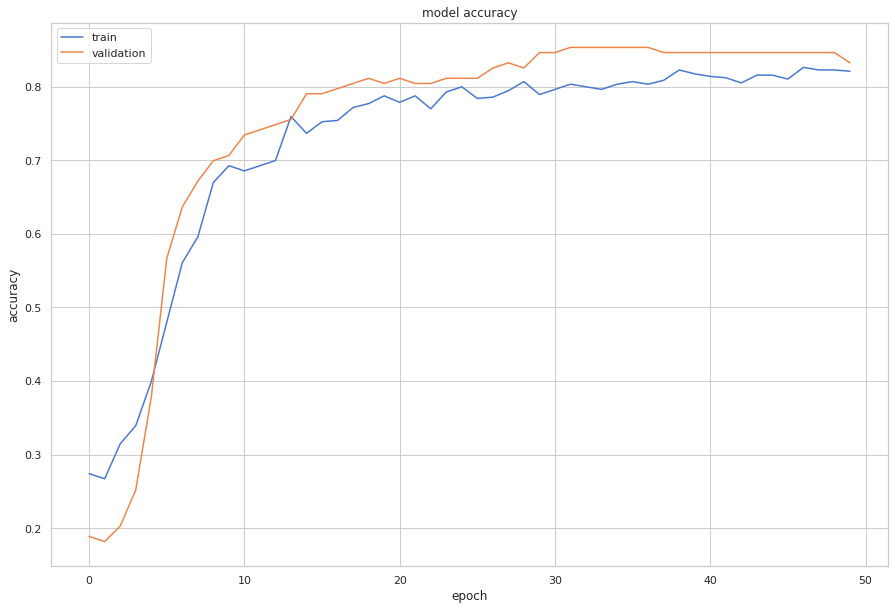

In [ ]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 3.3. Make Predictions on Test Set
[Back to Top](#scrollTo=3jq6wLfnS5_o)

Finally, we can attempt to predict which passengers in the test set survived.

In [ ]:
# calculate predictions
unlabeled['Survived'] = model.predict(X_unlabeled)
unlabeled['Survived'] = unlabeled['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = unlabeled[['PassengerId', 'Survived']]

14/14 [==============================] - 0s 2ms/step


In [ ]:
solution.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## 3.4. Output Final Predictions

[Back to Top](#scrollTo=3jq6wLfnS5_o)


In [ ]:
solution.to_csv("../output/Neural_Network_Solution.csv", index=False)

# Logistic Regression
[Back to Top](#scrollTo=3jq6wLfnS5_o)

Define the model:

In [ ]:

lr = LogisticRegression(penalty='none', max_iter = 1000)

Fit the model:

In [ ]:
seed(42)
set_seed(42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none')

Test the fit:

In [ ]:
accuracy_score(y_test, lr.predict(X_test))

0.8100558659217877

## Lasso

In [ ]:
lasso = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter = 1000)

In [ ]:
seed(42)
set_seed(42)
lasso.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')

In [ ]:
accuracy_score(y_test, lasso.predict(X_test))

0.8212290502793296

## Ridge

In [ ]:
ridge = LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter = 1000)

In [ ]:
seed(42)
set_seed(42)
ridge.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [ ]:
accuracy_score(y_test, ridge.predict(X_test))

0.8156424581005587

# Random Forrest
[Back to Top](#scrollTo=3jq6wLfnS5_o)

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
accuracy_score(y_test, rf.predict(X_test))

0.8379888268156425

# SVCs
[Back to Top](#scrollTo=3jq6wLfnS5_o)

## Linear SVC

In [ ]:
svc_lin = SVC(kernel='linear')

In [ ]:
seed(42)
set_seed(42)
svc_lin.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
accuracy_score(y_test, svc_lin.predict(X_test))

0.8212290502793296

## Polynomial SVC

In [ ]:
svc_pol = SVC(kernel='poly', degree=4)

In [ ]:
seed(42)
set_seed(42)
svc_pol.fit(X_train, y_train)

SVC(degree=4, kernel='poly')

In [ ]:
accuracy_score(y_test, svc_pol.predict(X_test))

0.8100558659217877

## RBF SVC

In [ ]:
svc_rbf = SVC(kernel='rbf')

In [ ]:
seed(42)
set_seed(42)
svc_rbf.fit(X_train, y_train)

SVC()

In [ ]:
accuracy_score(y_test, svc_rbf.predict(X_test))

0.8268156424581006

## Sigmoid SVC

In [ ]:
svc_sig = SVC(kernel='sigmoid')

In [ ]:
seed(42)
set_seed(42)
svc_sig.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [ ]:
accuracy_score(y_test, svc_sig.predict(X_test))

0.8044692737430168

# Naive Bayes

In [ ]:
nb = GaussianNB()

In [ ]:
seed(42)
set_seed(42)
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
accuracy_score(y_test, nb.predict(X_test))

0.44692737430167595